In [1]:
!pip install watermark
!pip install pytorch_lightning
!pip install segmentation_models_pytorch 
!pip install rasterio
!pip install pyproj
!pip install albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 KB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 KB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 47.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 46.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 K

In [2]:
!nvidia-smi

Tue Jan 10 04:58:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
%load_ext watermark
%watermark -v

Python implementation: CPython
Python version       : 3.8.16
IPython version      : 7.9.0



In [4]:
# importing the necessary libraries
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import rasterio
import warnings
import random
import pytorch_lightning as pl
import torch
import albumentations
import torch.nn as nn

In [5]:
!git clone https://github.com/AnupDesai/Semantic-Segmentation-of-Flood-Water-Imagery.git

Cloning into 'Semantic-Segmentation-of-Flood-Water-Imagery'...
remote: Enumerating objects: 1652, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 1652 (delta 3), reused 91 (delta 3), pack-reused 1561
Receiving objects: 100% (1652/1652), 837.72 MiB | 36.32 MiB/s, done.
Resolving deltas: 100% (103/103), done.
Checking out files: 100% (1628/1628), done.


In [6]:
IMAGE_PATH = Path("/content/Semantic-Segmentation-of-Flood-Water-Imagery/training_data")
DATA_FEATURES = IMAGE_PATH / "training_features"
DATA_LABELS = IMAGE_PATH / "training_labels"

training_data = pd.read_csv(IMAGE_PATH / "flood-training-metadata.csv", parse_dates=["scene_start"])
training_data.tail()

,image_id,chip_id,flood_id,polarization,location,scene_start
1079,wvy29_vv,wvy29,wvy,vv,UK,2019-02-15
1080,wvy30_vh,wvy30,wvy,vh,UK,2019-02-15
1081,wvy30_vv,wvy30,wvy,vv,UK,2019-02-15
1082,wvy31_vh,wvy31,wvy,vh,UK,2019-02-15
1083,wvy31_vv,wvy31,wvy,vv,UK,2019-02-15


**VISUALIZING THE NUMBER OF IMAGES PER LOCATION**

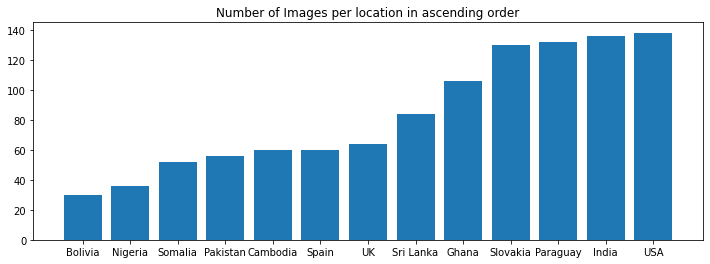

In [7]:
plt.figure(figsize=(12, 4))
counts= training_data["location"].value_counts().sort_values()
plt.bar(counts.index,counts.values)
plt.title("Number of Images per location in ascending order")
plt.show()

In [8]:
start_year = training_data.scene_start.dt.year
start_year_counts = training_data.groupby(start_year)["flood_id"].nunique()
print("Number of images with respect to each year: \n")
start_year_counts

Number of images with respect to each year: 



scene_start
2016    1
2017    2
2018    6
2019    3
2020    1
Name: flood_id, dtype: int64

In [9]:
training_data.groupby("flood_id")["scene_start"].nunique()

flood_id
awc    1
ayt    1
coz    1
hbe    1
hxu    1
jja    1
kuo    1
pxs    1
qus    1
qxb    1
tht    1
tnp    1
wvy    1
Name: scene_start, dtype: int64

In [10]:
img_path = DATA_FEATURES / f"{training_data.image_id[0]}.tif"

with rasterio.open(img_path) as img:
    metadata = img.meta
    bounds = img.bounds
    data = img.read(1)

print(f"Metadata of the image: {metadata} \n")
print(f"Bounding box of the image: {bounds}")

Metadata of the image: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 512, 'height': 512, 'count': 1, 'crs': CRS.from_epsg(32720), 'transform': Affine(10.0, 0.0, 314030.0,
       0.0, -10.0, 8585890.0)} 

Bounding box of the image: BoundingBox(left=314030.0, bottom=8580770.0, right=319150.0, top=8585890.0)


In [11]:
with rasterio.open(img_path) as img:
    gdal_mask = img.dataset_mask()

gdal_mask

array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0]], dtype=uint8)

In [12]:
with rasterio.open(img_path) as img:
    numpy_mask = img.read(1, masked=True)

numpy_mask

masked_array(
  data=[[-16.20801544189453, -17.71950912475586, -16.281352996826172,
         ..., --, --, --],
        [-15.328896522521973, -18.231857299804688, -16.451892852783203,
         ..., --, --, --],
        [-15.353134155273438, -16.888309478759766, -15.585904121398926,
         ..., --, --, --],
        ...,
        [-15.74166202545166, -15.230668067932129, -13.455254554748535,
         ..., --, --, --],
        [-15.498257637023926, -14.100983619689941, -13.110269546508789,
         ..., --, --, --],
        [-16.05560302734375, -14.112099647521973, -14.76084041595459,
         ..., --, --, --]],
  mask=[[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],
  fill_value=0.0,
  dtype=f

In [13]:
warnings.filterwarnings("ignore")

def scale_image_max_min(matrix):

    min_val = np.array([-23, -28, 0.2])
    max_val = np.array([0, -5, 1])
    w, h, d = matrix.shape
    matrix = np.reshape(matrix, [w * h, d]).astype(np.float64)
    matrix = (matrix - min_val[None, :]) / (
        max_val[None, :] - min_val[None, :]
    )
    matrix = np.reshape(matrix, [w, h, d])
    return matrix.clip(0, 1)


def false_composite(path_vv, path_vh):
    with rasterio.open(path_vv) as vv:
        vv_img = vv.read(1)
    with rasterio.open(path_vh) as vh:
        vh_img = vh.read(1)

    comp_img = np.stack((vv_img, vh_img), axis=-1)

    img = np.zeros((512, 512, 3), dtype=np.float32)
    img[:, :, :2] = comp_img.copy()
    img[:, :, 2] = comp_img[:, :, 0] / comp_img[:, :, 1]

    return scale_image_max_min(img)


def display_flood_images(random_state):

    f, ax = plt.subplots(1, 2, figsize=(9, 9))
    random_image = training_data.chip_id.sample(random_state=random_state).values[0]

    vv_path = DATA_FEATURES / f"{random_image}_vv.tif"
    vh_path = DATA_FEATURES / f"{random_image}_vh.tif"
    label_path = DATA_LABELS / f"{random_image}.tif"

    comp_img = false_composite(vv_path, vh_path)

    
    ax[0].imshow(comp_img)
    ax[0].set_title("Image without water label", fontsize=14)
    ax[0].axis(False)

    with rasterio.open(label_path) as lp:
        lp_img = lp.read(1)

    
    label = np.ma.masked_where((lp_img == 0) | (lp_img == 255), lp_img)

    ax[1].imshow(comp_img)
    ax[1].imshow(label, cmap="cool", alpha=1)
    ax[1].set_title("Image with Water Label", fontsize=14)
    ax[1].axis(False)

    plt.tight_layout(pad=5)
    plt.show()

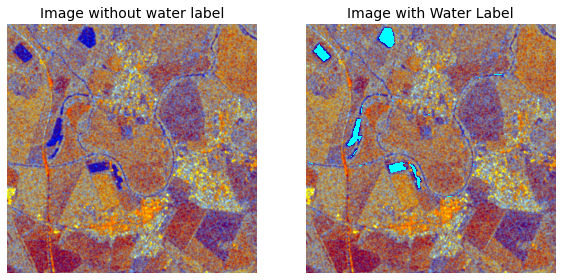

In [14]:
display_flood_images(7)

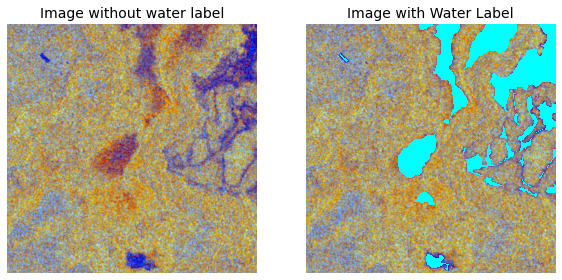

In [15]:
display_flood_images(36)

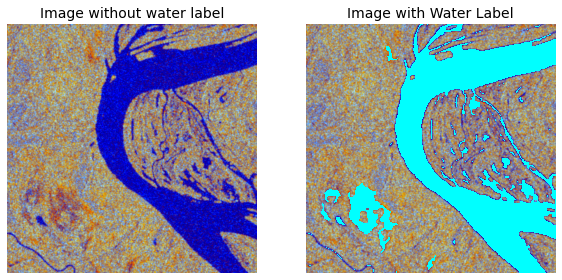

In [16]:
display_flood_images(62)

In [17]:
random.seed(42)  # set a seed for reproducibility
flood_ids = training_data.flood_id.unique().tolist()
val_flood_ids = random.sample(flood_ids, 4)
val_flood_ids

['tht', 'ayt', 'awc', 'hxu']

In [18]:
validation_dataframe = training_data[training_data.flood_id.isin(val_flood_ids)].copy()
train_dataframe = training_data[~training_data.flood_id.isin(val_flood_ids)].copy()
len(validation_dataframe) / (len(validation_dataframe) + len(train_dataframe)) * 100

16.420664206642066

In [19]:
train_dataframe.shape, validation_dataframe.shape

((906, 6), (178, 6))

**Build the model**

In [20]:
class FloodDataLoader(torch.utils.data.Dataset):
    
    def __init__(self, metadata, feature_id, label_id=None, torchTransforms=None):
        self.img_ids = metadata.chip_id.tolist()
        self.feature_id = feature_id
        self.label_id = label_id
        self.torchTransforms = torchTransforms

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        
        chip_id = self.img_ids[idx]
        vv_path = self.feature_id / f"{chip_id}_vv.tif"
        vh_path = self.feature_id / f"{chip_id}_vh.tif"
        with rasterio.open(vv_path) as vv:
            vv_img = vv.read(1)
        with rasterio.open(vh_path) as vh:
            vh_img = vh.read(1)
        buff_array=np.zeros_like(vv_img)
        res_arr = np.stack([vv_img, vh_img,buff_array], axis=-1)
      
        min_normalization = -77
        max_normalization = 26
        res_arr = np.clip(res_arr, min_normalization, max_normalization)
        res_arr = (res_arr - min_normalization) / (max_normalization - min_normalization)

        
        if self.torchTransforms:
            res_arr = self.torchTransforms(image=res_arr)["image"]
        res_arr = np.transpose(res_arr, [2, 0, 1])

        sample = {"chip_id": chip_id, "chip": res_arr}

         
        if self.label_id is not None:
            label_path = self.label_id / f"{chip_id}.tif"
            with rasterio.open(label_path) as lp:
                y_arr = lp.read(1)
            
            if self.torchTransforms:
                y_arr = self.torchTransforms(image=y_arr)["image"]
            sample["label"] = y_arr
      
        return sample

In [28]:
train_transform = albumentations.Compose(
    [
        albumentations.RandomCrop(256, 256),
        albumentations.HorizontalFlip(),
        
    ]
)

In [29]:
class CrossDiceLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.xe = torch.nn.CrossEntropyLoss(reduction="none")

    def forward(self, pred, true):
        mask_pixel = true.ne(255)

        # Cross-entropy loss
        temp_true = torch.where(~mask_pixel, 0, true)  
        crossDiceLoss = self.xe(pred, temp_true)
        crossDiceLoss = crossDiceLoss.masked_select(mask_pixel).mean()

        # Dice loss
        pred = torch.softmax(pred, dim=1)[:, 1]
        pred = pred.masked_select(mask_pixel)
        true = true.masked_select(mask_pixel)
        dice_loss = 1 - (2.0 * torch.sum(pred * true)) / (torch.sum(pred + true) + 1e-7)

        return (0.5 * crossDiceLoss) + (0.5 * dice_loss)


def IoU_fn(pred, true):

    mask_pixel = true.ne(255)  
    true = true.masked_select(mask_pixel).to("cpu")
    pred = pred.masked_select(mask_pixel).to("cpu")

    intersection = np.logical_and(true, pred)
    union = np.logical_or(true, pred)
    return intersection.sum(), union.sum()

In [30]:
class ResidualConvLayer(pl.LightningModule):
    def __init__(self, input_dim, output_dim, stride, padding):
        super(ResidualConvLayer, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.BatchNorm2d(input_dim),
            nn.ReLU(),
            nn.Conv2d(
                input_dim, output_dim, kernel_size=3, stride=stride, padding=padding
            ),
            nn.BatchNorm2d(output_dim),
            nn.ReLU(),
            nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=1),
        )
        self.skip_conv1 = nn.Sequential(
            nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(output_dim),
        )

    def forward(self, x):

        return self.conv_block1(x) + self.skip_conv1(x)


class Upsample(pl.LightningModule):
    def __init__(self, input_dim, output_dim, kernel, stride):
        super(Upsample, self).__init__()

        self.upsample = nn.ConvTranspose2d(
            input_dim, output_dim, kernel_size=kernel, stride=stride
        )

    def forward(self, x):
        return self.upsample(x)


class Squeeze_block(pl.LightningModule):
    def __init__(self, channel, reduction=16):
        super(Squeeze_block, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class Pyramid_pooling(pl.LightningModule):
    def __init__(self, in_dims, out_dims, rate=[6, 12, 18]):
        super(Pyramid_pooling, self).__init__()

        self.pyramid_block1 = nn.Sequential(
            nn.Conv2d(
                in_dims, out_dims, 3, stride=1, padding=rate[0], dilation=rate[0]
            ),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_dims),
        )
        self.pyramid_block2 = nn.Sequential(
            nn.Conv2d(
                in_dims, out_dims, 3, stride=1, padding=rate[1], dilation=rate[1]
            ),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_dims),
        )
        self.pyramid_block3 = nn.Sequential(
            nn.Conv2d(
                in_dims, out_dims, 3, stride=1, padding=rate[2], dilation=rate[2]
            ),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_dims),
        )

        self.output = nn.Conv2d(len(rate) * out_dims, out_dims, 1)
        self._init_weights()

    def forward(self, x):
        x1 = self.pyramid_block1(x)
        x2 = self.pyramid_block2(x)
        x3 = self.pyramid_block3(x)
        out = torch.cat([x1, x2, x3], dim=1)
        return self.output(out)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


class Upsample_(pl.LightningModule):
    def __init__(self, scale=2):
        super(Upsample_, self).__init__()

        self.upsample = nn.Upsample(mode="bilinear", scale_factor=scale)

    def forward(self, x):
        return self.upsample(x)


class Attention_unit_Block(pl.LightningModule):
    def __init__(self, input_encoder, input_decoder, output_dim):
        super(Attention_unit_Block, self).__init__()

        self.encoder_block = nn.Sequential(
            nn.BatchNorm2d(input_encoder),
            nn.ReLU(),
            nn.Conv2d(input_encoder, output_dim, 3, padding=1),
            nn.MaxPool2d(2, 2),
        )

        self.decoder_block = nn.Sequential(
            nn.BatchNorm2d(input_decoder),
            nn.ReLU(),
            nn.Conv2d(input_decoder, output_dim, 3, padding=1),
        )

        self.attn_conv_block = nn.Sequential(
            nn.BatchNorm2d(output_dim),
            nn.ReLU(),
            nn.Conv2d(output_dim, 1, 1),
        )

    def forward(self, x1, x2):
        out = self.encoder_block(x1) + self.decoder_block(x2)
        out = self.attn_conv_block(out)
        return out * x2

In [32]:
class ResUnetPlusPlus(pl.LightningModule):
    def __init__(self, channel, filters=[32, 64, 128, 256, 512]):
        super(ResUnetPlusPlus, self).__init__()

        self.input_layer = nn.Sequential(
            nn.Conv2d(channel, filters[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(filters[0]),
            nn.ReLU(),
            nn.Conv2d(filters[0], filters[0], kernel_size=3, padding=1),
        )
        self.input_skip = nn.Sequential(
            nn.Conv2d(channel, filters[0], kernel_size=3, padding=1)
        )

        self.squeeze_layer1 = Squeeze_block(filters[0])
        self.res_conv_layer1 = ResidualConvLayer(filters[0], filters[1], 2, 1)

        self.squeeze_layer2 = Squeeze_block(filters[1])
        self.res_conv_layer2 = ResidualConvLayer(filters[1], filters[2], 2, 1)

        self.squeeze_layer21 = Squeeze_block(filters[2])
        self.res_conv_layer21 = ResidualConvLayer(filters[2], filters[2], 2, 1)

        self.squeeze_layer22 = Squeeze_block(filters[2])
        self.res_conv_layer22 = ResidualConvLayer(filters[2], filters[2], 2, 1)

        self.squeeze_layer23 = Squeeze_block(filters[2])
        self.res_conv_layer23 = ResidualConvLayer(filters[2], filters[2], 2, 1)

        self.squeeze_layer24 = Squeeze_block(filters[2])
        self.res_conv_layer24 = ResidualConvLayer(filters[2], filters[2], 2, 1)
        
        self.squeeze_layer3 = Squeeze_block(filters[2])
        self.res_conv_layer3 = ResidualConvLayer(filters[2], filters[3], 2, 1)
        

        self.pyramid_bridge_layer = Pyramid_pooling(filters[3], filters[4])

        self.attn1 = Attention_unit_Block(filters[2], filters[4], filters[4])
        self.upsample1 = Upsample_(2)
        self.up_res_conv_layer1 = ResidualConvLayer(filters[4] + filters[2], filters[3], 1, 1)

        self.attn2 = Attention_unit_Block(filters[1], filters[3], filters[3])
        self.upsample2 = Upsample_(2)
        self.up_res_conv_layer2 = ResidualConvLayer(filters[3] + filters[1], filters[2], 1, 1)

        self.attn3 = Attention_unit_Block(filters[0], filters[2], filters[2])
        self.upsample3 = Upsample_(2)
        self.up_res_conv_layer3 = ResidualConvLayer(filters[2] + filters[0], filters[1], 1, 1)

        self.pyramid_out_layer = Pyramid_pooling(filters[1], filters[0])

        self.output_layer = nn.Sequential(nn.Conv2d(filters[0], 2, 1), nn.Sigmoid())

    def forward(self, x):
        x1 = self.input_layer(x) + self.input_skip(x)

        x2 = self.squeeze_layer1(x1)
        x2 = self.res_conv_layer1(x2)

        x3 = self.squeeze_layer2(x2)
        x3 = self.res_conv_layer2(x3)
        
        x4 = self.squeeze_layer3(x3)
        x4 = self.res_conv_layer3(x4)

        x5 = self.pyramid_bridge_layer(x4)

        x6 = self.attn1(x3, x5)
        x6 = self.upsample1(x6)
        x6 = torch.cat([x6, x3], dim=1)
        x6 = self.up_res_conv_layer1(x6)

        x7 = self.attn2(x2, x6)
        x7 = self.upsample2(x7)
        x7 = torch.cat([x7, x2], dim=1)
        x7 = self.up_res_conv_layer2(x7)

        x8 = self.attn3(x1, x7)
        x8 = self.upsample3(x8)
        x8 = torch.cat([x8, x1], dim=1)
        x8 = self.up_res_conv_layer3(x8)

        x9 = self.pyramid_out_layer(x8)
        out = self.output_layer(x9)

        return out

In [33]:
class FloodSemSegModel(pl.LightningModule):
    def __init__(self, training_data, val_metadata, hparams):
        super(FloodSemSegModel, self).__init__()
        self.hparams.update(hparams)
        self.feature_id = self.hparams.get("feature_id")
        self.label_id = self.hparams.get("label_id")
        self.train_img_ids = self.hparams.get("train_img_ids")
        self.val_img_ids = self.hparams.get("val_img_ids")
        self.transform = train_transform
        self.backbone = self.hparams.get("backbone", "resnet34")
        self.weights = self.hparams.get("weights", "imagenet")
        self.learning_rate = self.hparams.get("lr", 0.0001)
        self.max_epochs = self.hparams.get("max_epochs", 1000)
        self.min_epochs = self.hparams.get("min_epochs", 10)
        self.patience = self.hparams.get("patience", 4)
        self.num_workers = self.hparams.get("num_workers", 2)
        self.batch_size = self.hparams.get("batch_size", 32)
        self.fast_dev_run = self.hparams.get("fast_dev_run", False)
        self.val_sanity_checks = self.hparams.get("val_sanity_checks", 0)
        self.gpu = self.hparams.get("gpu", False)

        self.output_path = Path.cwd() / self.hparams.get("output_path", "model_outputs")
        self.output_path.mkdir(exist_ok=True)
        self.log_path = Path.cwd() / hparams.get("log_path", "tensorboard_logs")
        self.log_path.mkdir(exist_ok=True)

        
        self.train_dataset = self.config_dataframe(training_data, group="train")
        self.val_dataset = self.config_dataframe(val_metadata, group="val")

        
        self.model = self.build_model()
        self.trainer_params = self.access_training_param()

        # Track validation IOU globally (reset each epoch)
        self.intersection = 0
        self.union = 0


    def forward(self, image):
        return self.model(image)

    def training_step(self, batch, batch_idx):
        self.model.train()
        torch.set_grad_enabled(True)

        
        x = batch["chip"]
        y = batch["label"].long()
        if self.gpu:
            x, y = x.cuda(non_blocking=True), y.cuda(non_blocking=True)

        
        preds = self.forward(x)
        criterion = CrossDiceLoss()
        xe_dice_loss = criterion(preds, y)

        self.log(
            "xe_dice_loss",
            xe_dice_loss,
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )
        return xe_dice_loss

    def validation_step(self, batch, batch_idx):
        
        self.model.eval()
        torch.set_grad_enabled(False)

        
        x = batch["chip"]
        y = batch["label"].long()
        if self.gpu:
            x, y = x.cuda(non_blocking=True), y.cuda(non_blocking=True)

        
        preds = self.forward(x)
        preds = torch.softmax(preds, dim=1)[:, 1]
        preds = (preds > 0.5) * 1

        
        intersection, union = IoU_fn(preds, y)
        self.intersection += intersection
        self.union += union

        
        batch_iou = intersection / union
        self.log(
            "iou", batch_iou, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        return batch_iou

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=True,
        )

    def val_dataloader(self):        
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=0,
            shuffle=False,
            pin_memory=True,
        )

    def configure_optimizers(self):     
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="max", factor=0.5, patience=self.patience
        )
        scheduler = {
            "scheduler": scheduler,
            "interval": "epoch",
            "monitor": "iou_epoch",
        }  
        return [optimizer], [scheduler]

    def validation_epoch_end(self, outputs):
        self.intersection = 0
        self.union = 0

    def config_dataframe(self, metadata, group):
        if group == "train":
            df = FloodDataLoader(
                metadata=metadata,
                feature_id=self.feature_id,
                label_id=self.label_id,
                torchTransforms=self.transform,
            )
        elif group == "val":
            df = FloodDataLoader(
                metadata=metadata,
                feature_id=self.feature_id,
                label_id=self.label_id,
                torchTransforms=None,
            )
        return df

    def build_model(self): 
      ResUnetModel= ResUnetPlusPlus(channel=3)
      if self.gpu:
        ResUnetModel.cuda()
      return ResUnetModel
    

    def access_training_param(self):
        checkpoint_callback = pl.callbacks.ModelCheckpoint(
            dirpath=self.output_path,
            monitor="iou_epoch",
            mode="max",
            verbose=True,
        )
        early_stop_callback = pl.callbacks.early_stopping.EarlyStopping(
            monitor="iou_epoch",
            patience=(self.patience * 3),
            mode="max",
            verbose=True,
        )
      
        logger = pl.loggers.TensorBoardLogger(self.log_path, name="benchmark-model")
        trainer_params = {
            "callbacks": [checkpoint_callback, early_stop_callback],
            "max_epochs": self.max_epochs,
            "min_epochs": self.min_epochs,
            "default_root_dir": self.output_path,
            "logger": logger,
            "gpus": None if not self.gpu else 1,
            "fast_dev_run": self.fast_dev_run,
            "num_sanity_val_steps": self.val_sanity_checks,
        }
        return trainer_params

    def fit(self):
        self.trainer = pl.Trainer(**self.trainer_params)
        self.trainer.fit(self)

In [34]:
torch.cuda.empty_cache()
hparams = {
    # Required hparams
    "feature_id": DATA_FEATURES,
    "label_id": DATA_LABELS,
    "backbone": "resnet34",
    "weights": "imagenet",
    "lr": 1e-3,
    "min_epochs": 10,
    "max_epochs": 200,
    "patience": 4,
    "batch_size": 5,
    "num_workers": 2,
    "val_sanity_checks": 0,
    "fast_dev_run": False,
    "output_path": "model_outputs",
    "log_path": "tensorboard_logs",
    "gpu": torch.cuda.is_available(),
}

flood_model = FloodSemSegModel(training_data=train_dataframe, val_metadata=validation_dataframe, hparams=hparams)
flood_model.fit()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type            | Params
------------------------------------------
0 | model | ResUnetPlusPlus | 16.3 M
------------------------------------------
16.3 M    Trainable params
0         Non-trainable params
16.3 M    Total params
65.059    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric iou_epoch improved. New best score: 0.437
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 182: 'iou_epoch' reached 0.43658 (best 0.43658), saving model to '/content/model_outputs/epoch=0-step=182-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 364: 'iou_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 546: 'iou_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 728: 'iou_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 910: 'iou_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 1092: 'iou_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 1274: 'iou_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 1456: 'iou_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 1638: 'iou_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 1820: 'iou_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 2002: 'iou_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 2184: 'iou_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric iou_epoch did not improve in the last 12 records. Best score: 0.437. Signaling Trainer to stop.
INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 2366: 'iou_epoch' was not in top 1
